In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import gc
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
gc.collect()

0

In [ ]:
df_train_vrd_rel = pd.read_hdf('vrd/temp/df_train_vrd_rel.h5', 'df_train_vrd_rel')
df_valid_vrd_rel = pd.read_hdf('vrd/temp/df_valid_vrd_rel.h5', 'df_valid_vrd_rel')
df_test_rel = pd.read_hdf('vrd/temp/df_test_rel.h5', 'df_test_rel')

## 1. Train Relationship Model

### 1.1 Prepare Features

In [4]:
def computeAspectRatio1(row):
    return (row["XMax1"]-row["XMin1"])/(row["YMax1"]-row["YMin1"])

def computeAspectRatio2(row):
    return (row["XMax2"]-row["XMin2"])/(row["YMax2"]-row["YMin2"])

def computeSize1(row):
    return (row["XMax1"]-row["XMin1"])*(row["YMax1"]-row["YMin1"])

def computeSize2(row):
    return (row["XMax2"]-row["XMin2"])*(row["YMax2"]-row["YMin2"])

def computeSizeDiff(row):
    return computeSize1(row)/computeSize2(row)

def computeCenterX1(row):
    return (row["XMax1"]-row["XMin1"])/2+row["XMin1"]

def computeCenterX2(row):
    return (row["XMax2"]-row["XMin2"])/2+row["XMin2"]

def computeCenterY1(row):
    return (row["YMax1"]-row["YMin1"])/2+row["YMin1"]

def computeCenterY2(row):
    return (row["YMax2"]-row["YMin2"])/2+row["YMin2"]

def computeCenterXDiff(row):
    return (computeCenterX1(row)-computeCenterX2(row)) / (row["XMax1"]-row["XMin1"])
    
def computeCenterYDiff(row):
    return (computeCenterY1(row)-computeCenterY2(row)) / (row["YMax1"]-row["YMin1"])

def computeIOU(row):
    xA = max(row["XMin1"], row["XMin2"])
    yA = max(row["YMin1"], row["YMin2"])
    xB = min(row["XMax1"], row["XMax2"])
    yB = min(row["YMax1"], row["YMax2"])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = (row["XMax1"] - row["XMin1"]) * (row["YMax1"] - row["YMin1"])
    boxBArea = (row["XMax2"] - row["XMin2"]) * (row["YMax2"] - row["YMin2"])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def computeIntersection1(row):
    xA = max(row["XMin1"], row["XMin2"])
    yA = max(row["YMin1"], row["YMin2"])
    xB = min(row["XMax1"], row["XMax2"])
    yB = min(row["YMax1"], row["YMax2"])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    return interArea / computeSize1(row)

def computeIntersection2(row):
    xA = max(row["XMin1"], row["XMin2"])
    yA = max(row["YMin1"], row["YMin2"])
    xB = min(row["XMax1"], row["XMax2"])
    yB = min(row["YMax1"], row["YMax2"])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    return interArea / computeSize2(row)

def add_features(df):
    df["AspectRatio1"] = df.progress_apply(lambda row: computeAspectRatio1(row), axis=1)
    df["AspectRatio2"] = df.progress_apply(lambda row: computeAspectRatio2(row), axis=1)

#     df["Size1"] = df.progress_apply(lambda row: computeSize1(row), axis=1)
#     df["Size2"] = df.progress_apply(lambda row: computeSize2(row), axis=1)
    
    df["sizeDiff"] = df.progress_apply(lambda row: computeSizeDiff(row), axis=1)

#     df["CenterX1"] = df.progress_apply(lambda row: computeCenterX1(row), axis=1)
#     df["CenterX2"] = df.progress_apply(lambda row: computeCenterX2(row), axis=1)
#     df["CenterY1"] = df.progress_apply(lambda row: computeCenterY1(row), axis=1)
#     df["CenterY2"] = df.progress_apply(lambda row: computeCenterY2(row), axis=1)

    df["XCenterDiff"] = df.progress_apply(lambda row: computeCenterXDiff(row), axis=1)
    df["YCenterDiff"] = df.progress_apply(lambda row: computeCenterYDiff(row), axis=1)

#     df["CenterDiff"] = df.progress_apply(lambda row: computeCenterDiff(row), axis=1)
#     df["CenterX"] = df.progress_apply(lambda row: computeCenterX(row), axis=1)
#     df["CenterY"] = df.progress_apply(lambda row: computeCenterY(row), axis=1)

    df["IOU"] = df.progress_apply(lambda row: computeIOU(row), axis=1)
    
    df["InterArea1"] = df.progress_apply(lambda row: computeIntersection1(row), axis=1)
    df["InterArea2"] = df.progress_apply(lambda row: computeIntersection2(row), axis=1)

In [7]:
add_features(df_train_vrd_rel)

100%|██████████| 180626/180626 [00:30<00:00, 5851.47it/s]


In [5]:
add_features(df_valid_vrd_rel)

100%|██████████| 1418/1418 [00:00<00:00, 4147.85it/s]


In [9]:
add_features(df_test_rel)

100%|██████████| 3601704/3601704 [10:47<00:00, 5559.99it/s]


In [10]:
df_train_vrd_rel.to_hdf('vrd/df_train_vrd_rel_features2.h5', key='df_train_vrd_rel', mode='w', format='t')
df_valid_vrd_rel.to_hdf('vrd/df_valid_vrd_rel_features2.h5', key='df_valid_vrd_rel', mode='w', format='t')
df_test_rel.to_hdf('vrd/df_test_rel_features2.h5', key='df_test_rel', mode='w', format='t')

### 1.2 Load Features

In [3]:
df_train_vrd_rel = pd.read_hdf('vrd/df_train_vrd_rel_features2.h5', 'df_train_vrd_rel')
df_valid_vrd_rel = pd.read_hdf('vrd/df_valid_vrd_rel_features2.h5', 'df_valid_vrd_rel')
df_test_rel = pd.read_hdf('vrd/df_test_rel_features2.h5', 'df_test_rel') 

In [4]:
drop_cols = ["XMin1", "XMax1", "YMin1", "YMax1", "XMin2", "XMax2", "YMin2", "YMax2"]
X_train = df_train_vrd_rel.drop(drop_cols+['ImageID','RelationshipLabel'], axis=1)
y_train = df_train_vrd_rel['RelationshipLabel'].cat.codes 
X_valid = df_valid_vrd_rel.drop(drop_cols+['ImageID','RelationshipLabel'], axis=1)
y_valid = df_valid_vrd_rel['RelationshipLabel'].cat.codes # pd.get_dummies(df_valid_vrd_rel['RelationshipLabel']).values

In [5]:
X_test = df_test_rel.drop(drop_cols+['ImageID','Confidence1','Confidence2','RelationshipLabel'], axis=1)

In [6]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)

In [39]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'multiclass',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 9,
          'metric' : 'multi_logloss'
          }

In [40]:
gridParams = {
    'learning_rate': [0.01, 0.05, 0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27, 42, 60,64],
    'boosting_type' : ['gbdt'],
    'objective' : ['multi_logloss'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

In [41]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'multi_logloss',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [42]:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

In [43]:
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

In [44]:
grid.fit(X_train, y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 13.9min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=5, num_leaves=31,
        objective='multi_logloss', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.05, 0.07], 'n_estimators': [8, 16], 'num_leaves': [20, 24, 27, 42, 60, 64], 'boosting_type': ['gbdt'], 'objective': ['multi_logloss'], 'random_state': [501], 'colsample_bytree': [0.64, 0.65], 'subsample': [0.7, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [45]:
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 16, 'num_leaves': 60, 'objective': 'multi_logloss', 'random_state': 501, 'subsample': 0.75}
0.898840698459801


In [46]:
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']

In [47]:
# params = {
#         'objective': 'multiclass',
#         'boosting': 'gbdt',
#         'learning_rate': 0.01 ,
#         'verbose': 0,
#         'num_leaves': 64,
#         'bagging_fraction': 0.95,
#         'bagging_freq': 1,
#         'bagging_seed': 1,
#         'feature_fraction': 0.9,
#         'feature_fraction_seed': 1,
#         'max_bin': 512,
#         'num_rounds': 10000,
#         'metric': ['multi_logloss'],
#         'num_class': 9
#     }
cats_dict = dict( zip( df_valid_vrd_rel['RelationshipLabel'].cat.codes, df_valid_vrd_rel['RelationshipLabel'] ) )

In [48]:
lgbm_model = lgb.train(params, train_set = lgb_train, num_boost_round=1000, valid_sets = lgb_valid, verbose_eval=5, early_stopping_rounds=40)

Training until validation scores don't improve for 40 rounds.
[5]	valid_0's multi_logloss: 1.06967
[10]	valid_0's multi_logloss: 0.852469
[15]	valid_0's multi_logloss: 0.70029
[20]	valid_0's multi_logloss: 0.587637
[25]	valid_0's multi_logloss: 0.51702
[30]	valid_0's multi_logloss: 0.461375
[35]	valid_0's multi_logloss: 0.426795
[40]	valid_0's multi_logloss: 0.401133
[45]	valid_0's multi_logloss: 0.384028
[50]	valid_0's multi_logloss: 0.362042
[55]	valid_0's multi_logloss: 0.344015
[60]	valid_0's multi_logloss: 0.331547
[65]	valid_0's multi_logloss: 0.322218
[70]	valid_0's multi_logloss: 0.314185
[75]	valid_0's multi_logloss: 0.306645
[80]	valid_0's multi_logloss: 0.301659
[85]	valid_0's multi_logloss: 0.29796
[90]	valid_0's multi_logloss: 0.294685
[95]	valid_0's multi_logloss: 0.291267
[100]	valid_0's multi_logloss: 0.288739
[105]	valid_0's multi_logloss: 0.287229
[110]	valid_0's multi_logloss: 0.285504
[115]	valid_0's multi_logloss: 0.284259
[120]	valid_0's multi_logloss: 0.283067
[1

In [49]:
# lgbm_model = lgb.train(params, train_set = lgb_train, num_boost_round=1000, valid_sets = lgb_valid, verbose_eval=5, early_stopping_rounds=40)

In [50]:
lgbm_model.save_model('model3.txt')

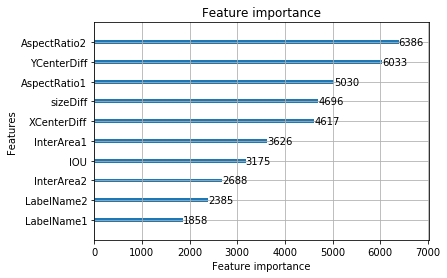

In [51]:
lgb.plot_importance(lgbm_model)

### 1.3 Evaluate

In [52]:
lgbm_model = lgb.Booster(model_file='model3.txt')  # init model

In [53]:
batch_size = 5000
len(X_test)

3601704

In [54]:
for i in tqdm(range(0,len(X_test),batch_size)):
    total_batch_size = min(i+batch_size, len(X_test))
    predictions = lgbm_model.predict(X_test[i:total_batch_size], num_iteration=lgbm_model.best_iteration)
    predict_rel_label = predictions.argmax(axis=1)
    cat_pred_rel_label = [cats_dict[x] for x in predict_rel_label]
    df_test_rel[i:total_batch_size]["RelationshipLabel"] = cat_pred_rel_label



  0%|          | 0/721 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


  0%|          | 1/721 [00:00<04:17,  2.79it/s]

  0%|          | 2/721 [00:00<04:14,  2.83it/s]

  0%|          | 3/721 [00:01<04:12,  2.85it/s]

  1%|          | 4/721 [00:01<04:09,  2.87it/s]

  1%|          | 5/721 [00:01<04:06,  2.90it/s]

  1%|          | 6/721 [00:02<04:07,  2.89it/s]

  1%|          | 7/721 [00:02<04:06,  2.90it/s]

  1%|          | 8/721 [00:02<04:06,  2.89it/s]

  1%|          | 9/721 [00:03<04:04,  2.92it/s]

  1%|▏         | 10/721 [00:03<04:05,  2.89it/s]

  2%|▏         | 11/721 [00:03<04:05,  2.90it/s]

  2%|▏         | 12/721 [00:04<04:04,  2.90it/s]

  2%|▏         | 13/721 

 19%|█▉        | 139/721 [00:48<03:30,  2.77it/s]

 19%|█▉        | 140/721 [00:49<03:30,  2.76it/s]

 20%|█▉        | 141/721 [00:49<03:29,  2.77it/s]

 20%|█▉        | 142/721 [00:49<03:26,  2.81it/s]

 20%|█▉        | 143/721 [00:50<03:24,  2.82it/s]

 20%|█▉        | 144/721 [00:50<03:23,  2.84it/s]

 20%|██        | 145/721 [00:50<03:21,  2.86it/s]

 20%|██        | 146/721 [00:51<03:21,  2.86it/s]

 20%|██        | 147/721 [00:51<03:19,  2.88it/s]

 21%|██        | 148/721 [00:51<03:18,  2.88it/s]

 21%|██        | 149/721 [00:52<03:19,  2.87it/s]

 21%|██        | 150/721 [00:52<03:18,  2.88it/s]

 21%|██        | 151/721 [00:53<03:21,  2.83it/s]

 21%|██        | 152/721 [00:53<03:19,  2.85it/s]

 21%|██        | 153/721 [00:53<03:19,  2.85it/s]

 21%|██▏       | 154/721 [00:54<03:20,  2.83it/s]

 21%|██▏       | 155/721 [00:54<03:21,  2.81it/s]

 22%|██▏       | 156/721 [00:54<03:19,  2.83it/s]

 22%|██▏       | 157/721 [00:55<03:18,  2.84it/s]

 22%|██▏       | 158/721 [00:55

 39%|███▉      | 282/721 [01:38<02:30,  2.92it/s]

 39%|███▉      | 283/721 [01:39<02:31,  2.90it/s]

 39%|███▉      | 284/721 [01:39<02:32,  2.86it/s]

 40%|███▉      | 285/721 [01:40<02:31,  2.88it/s]

 40%|███▉      | 286/721 [01:40<02:29,  2.91it/s]

 40%|███▉      | 287/721 [01:40<02:30,  2.88it/s]

 40%|███▉      | 288/721 [01:41<02:28,  2.92it/s]

 40%|████      | 289/721 [01:41<02:27,  2.94it/s]

 40%|████      | 290/721 [01:41<02:28,  2.90it/s]

 40%|████      | 291/721 [01:42<02:27,  2.91it/s]

 40%|████      | 292/721 [01:42<02:27,  2.90it/s]

 41%|████      | 293/721 [01:42<02:29,  2.87it/s]

 41%|████      | 294/721 [01:43<02:30,  2.84it/s]

 41%|████      | 295/721 [01:43<02:30,  2.83it/s]

 41%|████      | 296/721 [01:43<02:30,  2.82it/s]

 41%|████      | 297/721 [01:44<02:28,  2.86it/s]

 41%|████▏     | 298/721 [01:44<02:28,  2.84it/s]

 41%|████▏     | 299/721 [01:44<02:28,  2.84it/s]

 42%|████▏     | 300/721 [01:45<02:29,  2.82it/s]

 42%|████▏     | 301/721 [01:45

 59%|█████▉    | 425/721 [02:29<01:46,  2.78it/s]

 59%|█████▉    | 426/721 [02:29<01:45,  2.81it/s]

 59%|█████▉    | 427/721 [02:29<01:44,  2.81it/s]

 59%|█████▉    | 428/721 [02:30<01:43,  2.83it/s]

 60%|█████▉    | 429/721 [02:30<01:43,  2.81it/s]

 60%|█████▉    | 430/721 [02:31<01:44,  2.80it/s]

 60%|█████▉    | 431/721 [02:31<01:44,  2.76it/s]

 60%|█████▉    | 432/721 [02:31<01:43,  2.79it/s]

 60%|██████    | 433/721 [02:32<01:43,  2.79it/s]

 60%|██████    | 434/721 [02:32<01:42,  2.80it/s]

 60%|██████    | 435/721 [02:32<01:42,  2.80it/s]

 60%|██████    | 436/721 [02:33<01:42,  2.79it/s]

 61%|██████    | 437/721 [02:33<01:41,  2.79it/s]

 61%|██████    | 438/721 [02:33<01:41,  2.79it/s]

 61%|██████    | 439/721 [02:34<01:40,  2.81it/s]

 61%|██████    | 440/721 [02:34<01:38,  2.84it/s]

 61%|██████    | 441/721 [02:34<01:39,  2.82it/s]

 61%|██████▏   | 442/721 [02:35<01:38,  2.84it/s]

 61%|██████▏   | 443/721 [02:35<01:38,  2.83it/s]

 62%|██████▏   | 444/721 [02:35

 79%|███████▉  | 568/721 [03:19<00:54,  2.81it/s]

 79%|███████▉  | 569/721 [03:20<00:54,  2.79it/s]

 79%|███████▉  | 570/721 [03:20<00:53,  2.81it/s]

 79%|███████▉  | 571/721 [03:20<00:53,  2.80it/s]

 79%|███████▉  | 572/721 [03:21<00:52,  2.81it/s]

 79%|███████▉  | 573/721 [03:21<00:51,  2.86it/s]

 80%|███████▉  | 574/721 [03:21<00:52,  2.82it/s]

 80%|███████▉  | 575/721 [03:22<00:51,  2.81it/s]

 80%|███████▉  | 576/721 [03:22<00:51,  2.81it/s]

 80%|████████  | 577/721 [03:22<00:51,  2.82it/s]

 80%|████████  | 578/721 [03:23<00:49,  2.86it/s]

 80%|████████  | 579/721 [03:23<00:50,  2.81it/s]

 80%|████████  | 580/721 [03:23<00:49,  2.83it/s]

 81%|████████  | 581/721 [03:24<00:49,  2.84it/s]

 81%|████████  | 582/721 [03:24<00:49,  2.81it/s]

 81%|████████  | 583/721 [03:25<00:48,  2.84it/s]

 81%|████████  | 584/721 [03:25<00:48,  2.83it/s]

 81%|████████  | 585/721 [03:25<00:48,  2.83it/s]

 81%|████████▏ | 586/721 [03:26<00:48,  2.81it/s]

 81%|████████▏ | 587/721 [03:26

 99%|█████████▊| 711/721 [04:10<00:03,  2.81it/s]

 99%|█████████▉| 712/721 [04:10<00:03,  2.83it/s]

 99%|█████████▉| 713/721 [04:11<00:02,  2.82it/s]

 99%|█████████▉| 714/721 [04:11<00:02,  2.82it/s]

 99%|█████████▉| 715/721 [04:11<00:02,  2.84it/s]

 99%|█████████▉| 716/721 [04:12<00:01,  2.82it/s]

 99%|█████████▉| 717/721 [04:12<00:01,  2.84it/s]

100%|█████████▉| 718/721 [04:12<00:01,  2.86it/s]

100%|█████████▉| 719/721 [04:13<00:00,  2.85it/s]

100%|█████████▉| 720/721 [04:13<00:00,  2.83it/s]

100%|██████████| 721/721 [04:13<00:00,  3.30it/s]

### 1.4 THIS IS WHAT WE WANT WHEN WE COMBINE

In [55]:
df_test_rel.to_csv("submission_rel2.csv",index=False)